# Méthode du synthetic control pour mesurer l'effet des "incentives" à la vaccination aux États-Unis

## 1. Définitions et analyse paramètres

In [34]:
import numpy as np
import pandas as pd

states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# On supprime le New Hampshire à cause d'irrégularités dans ses données vaccinales

states_names = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas",
                "CA":"California", "CO":"Colorado", "CT":"Connecticut",
                "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii",
                "ID":"Idaho", "IL":"Illinois", "IN":"Indiana", "IA":"Iowa",
                "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine",
                "MD":"Maryland", "MA":"Massachusetts", "MI":"Michigan",
                "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
                "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey",
                "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
                "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon",
                "PA":"Pennsylvania", "RI":"Rhode Island", "SC":"South Carolina",
                "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah",
                "VT":"Vermont", "VA":"Virginia", "WA":"Washington", "WV":"West Virginia",
                "WI":"Wisconsin", "WY":"Wyoming"}

In [35]:
# Importation des données de vaccination

df_states = {}
for X in states:
  # fichiers csv à trouver dans le drive partagé
    path = 'state_vax_csv/'+X+'.csv'
    df_states[X] = pd.read_csv(path, sep=',' )
    df_states[X] = df_states[X].loc[::-1].reset_index(drop=True)
    df_states[X] = df_states[X].loc[67:,:].reset_index()

In [36]:
df_states['AK'].loc[:,["Date", "Administered_Dose1_Pop_Pct", 'Administered_Dose1_Recip_12_17_Pct','Administered_Dose1_Recip_18_64_Pct','Administered_Dose1_Recip_65PlusPop_Pct']]

,Date,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_12_17_Pct,Administered_Dose1_Recip_18_64_Pct,Administered_Dose1_Recip_65PlusPop_Pct
0,02/19/2021,19.7,0.0,31.2,0.0
1,02/20/2021,20.3,0.0,32.2,0.0
2,02/21/2021,20.9,0.0,33.0,0.0
3,02/22/2021,21.0,0.0,33.3,0.0
4,02/23/2021,21.1,0.0,33.5,0.0
...,...,...,...,...,...
448,05/13/2022,69.8,62.9,79.4,95.0
449,05/14/2022,69.8,63.0,79.4,95.0
450,05/15/2022,69.8,63.0,79.4,95.0
451,05/16/2022,69.8,63.0,79.4,95.0


In [37]:
# On remarque qu'il y a des problèmes dans le report des doses administrées : il arrive que le pourcentage de doses
# administrées diminue, alors qu'il ne devrait qu'augmenter ou rester constant (cf. explications dans le rapport)
# On décide donc de remédier à ces erreurs en fixant un seuil pour éviter que les données ne diminuent
# Dans un second temps, on effectue une interpolation sur la période où l'on constate des erreurs de report

tf = len(df_states['CA'])

for seg in ["Administered_Dose1_Pop_Pct", "Administered_Dose1_Recip_12_17_Pct", "Administered_Dose1_Recip_18_64_Pct", "Administered_Dose1_Recip_65PlusPop_Pct"]:
    for state in states:
        for t in range(1,tf):
            if df_states[state].loc[t, seg] < df_states[state].loc[t-1, seg]:
                #on a un souci à partir du temps t
                j = t
                flag = True
                while j < tf and flag:
                    if df_states[state].loc[j, seg] >= df_states[state].loc[t-1, seg]:
                        #on a trouvé le plus petit indice pour lequel les données redeviennent cohérentes
                        a_t = df_states[state].loc[t-1, seg]
                        a_j = df_states[state].loc[j, seg]
                        
                        #on interpole linéairement
                        for i in range(t,j):
                            df_states[state].loc[i, seg] = ((a_t-a_j)/(t-1-j))*(i-j) + a_j
                        flag = False
                    j +=1 
                        
                if flag:
                    #on a pas trouvé de plus petit indice: on crée un plateau à partir du temps t
                    for i in range(t,tf):
                        df_states[state].loc[i, seg] = df_states[state].loc[t-1, seg]

In [38]:
# On s'intéresse à la colonne du pourcentage de personnes ayant reçu au moins une dose. 
# C'est notre "response variable" que l'on cherche à modéliser après l'intervention.

df_dose1 = {"Pop":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}

for X in states:
    df_dose1["Pop"][X] = df_states[X].loc[:,'Administered_Dose1_Pop_Pct']
    df_dose1["12-17"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_12_17_Pct']
    df_dose1["18-64"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_18_64_Pct']
    df_dose1["65Plus"][X] = df_states[X].loc[:,'Administered_Dose1_Recip_65PlusPop_Pct']

ls_dose1 = {"Pop":{} ,"12-17":{}, "18-64":{}, "65Plus":{}}
for k in ["Pop", "12-17", "18-64", "65Plus"]:
    for X in states:
        ls_dose1[k][X] = df_dose1[k][X].to_numpy()

In [39]:
df_prm = pd.read_excel('parameters.xlsx', 'By state code', index_col=0)
df_prm = df_prm.drop(columns=['Population'])
prm = df_prm.to_numpy()
    
state_vector = {}
for i in range(len(states)):
    state_vector[states[i]] = prm[i]

In [40]:
df_prm.to_csv('Résultats/df_prm.csv', ',')
df_prm.head()

,Under 18 years old,Over 65 years old,Median age,White,Black,American Indian,Asian,Hawaiian,Higher education achievement,High school achievement,...,Median income (in USD),2016 Trump vote share,2020 Trump vote share,Governor: democrat (1) / republican (0),Gun ownership rate,Adult obesity rate,Hypertension,Number of Covid-19 deaths in 2020 / State population,People without healthcare,Access to care score
State code,,,,,,,,,,,,,,,,,,,,,
AL,0.222,0.178,39.0,0.6809,0.2664,0.0052,0.0136,0.0005,0.26,0.86,...,50536.0,0.6208,0.620,0.0,0.555,0.361,0.425,0.000021,0.097,0.136664
AK,0.246,0.131,34.0,0.6458,0.0328,0.1489,0.0623,0.0125,0.30,0.93,...,77640.0,0.5128,0.528,0.0,0.645,0.305,0.328,0.000050,0.115,0.577950
AZ,0.225,0.185,38.0,0.7722,0.0450,0.0450,0.0331,0.0021,0.30,0.87,...,58945.0,0.4867,0.491,0.0,0.463,0.314,0.325,0.000013,0.111,0.286535
AR,0.232,0.177,38.0,0.7672,0.1532,0.0068,0.0152,0.0029,0.23,0.87,...,47597.0,0.6057,0.624,0.0,0.572,0.374,0.410,0.000030,0.091,0.267585
CA,0.225,0.152,37.0,0.5970,0.0579,0.0077,0.1449,0.0040,0.34,0.83,...,75235.0,0.3162,0.343,1.0,0.283,0.262,0.278,0.000002,0.078,0.574505


In [41]:
# Normalisation et moyenne à 0

df_prm_scaled = (df_prm-df_prm.mean())/df_prm.std()
prm_scaled = df_prm_scaled.to_numpy()

state_vector_scaled = {}
for i in range(len(states)):
    state_vector_scaled[states[i]] = prm_scaled[i]

In [42]:
df_prm_scaled.to_csv('Résultats/df_prm_scaled.csv', ',')
df_prm_scaled.head()

,Under 18 years old,Over 65 years old,Median age,White,Black,American Indian,Asian,Hawaiian,Higher education achievement,High school achievement,...,Median income (in USD),2016 Trump vote share,2020 Trump vote share,Governor: democrat (1) / republican (0),Gun ownership rate,Adult obesity rate,Hypertension,Number of Covid-19 deaths in 2020 / State population,People without healthcare,Access to care score
State code,,,,,,,,,,,,,,,,,,,,,
AL,-0.009301,0.196143,0.159599,-0.655402,1.685610,-0.386748,-0.518640,-0.211357,-1.012667,-1.320839,...,-1.175728,1.256236,1.152518,-0.951113,0.864443,0.961142,2.157888,-0.244389,0.401891,-1.630616
AK,1.230784,-2.204567,-1.940392,-0.930504,-0.769213,4.502030,0.359097,0.632946,-0.245495,1.247459,...,1.458899,0.199490,0.261945,-0.951113,1.547017,-0.511872,-0.072665,0.576988,0.989070,0.358003
AZ,0.145710,0.553696,-0.260399,0.060178,-0.641007,0.967277,-0.167184,-0.098783,-0.245495,-0.953939,...,-0.358336,-0.055890,-0.096221,-0.951113,0.166700,-0.275138,-0.141652,-0.498358,0.858586,-0.955236
AR,0.507401,0.145064,-0.260399,0.020989,0.496030,-0.332314,-0.489802,-0.042497,-1.588047,-0.953939,...,-1.461411,1.108487,1.191238,-0.951113,0.993373,1.303091,1.812957,0.015860,0.206165,-1.040629
CA,0.145710,-1.131909,-0.680397,-1.312982,-0.505445,-0.301696,1.847825,0.034898,0.521677,-2.421538,...,1.225123,-1.724178,-1.528882,1.030372,-1.198449,-1.642936,-1.222435,-0.811085,-0.217909,0.342477


In [43]:
# Matrice des corrélations

df_prm_corr = df_prm_scaled.corr()
df_prm_corr.to_csv('Résultats/df_prm_corr.csv', ',')
df_prm_corr.head()

,Under 18 years old,Over 65 years old,Median age,White,Black,American Indian,Asian,Hawaiian,Higher education achievement,High school achievement,...,Median income (in USD),2016 Trump vote share,2020 Trump vote share,Governor: democrat (1) / republican (0),Gun ownership rate,Adult obesity rate,Hypertension,Number of Covid-19 deaths in 2020 / State population,People without healthcare,Access to care score
Under 18 years old,1.000000,-0.783883,-0.913930,-0.063072,0.016944,0.311793,-0.100505,-0.006747,-0.309742,-0.134407,...,-0.131387,0.414463,0.520524,-0.328714,0.390922,-0.189033,-0.052678,0.138105,0.510472,-0.498972
Over 65 years old,-0.783883,1.000000,0.883972,0.201119,-0.104766,-0.198845,-0.025524,0.071442,-0.087218,0.173716,...,-0.246880,-0.054832,-0.121539,0.159378,-0.092461,0.273851,0.192577,0.061694,-0.358531,0.284428
Median age,-0.913930,0.883972,1.000000,0.179586,0.017228,-0.364334,-0.037116,-0.066593,0.117245,0.120762,...,-0.059406,-0.205970,-0.315887,0.256799,-0.251097,0.263279,0.205389,-0.152315,-0.405454,0.343940
White,-0.063072,0.201119,0.179586,1.000000,-0.536897,0.015582,-0.717981,-0.593799,-0.048032,0.412510,...,-0.264011,0.351152,0.349000,-0.170398,0.403850,0.096187,-0.112120,0.253897,-0.113271,0.171361
Black,0.016944,-0.104766,0.017228,-0.536897,1.000000,-0.330084,-0.103482,-0.178020,-0.170789,-0.543158,...,-0.213725,0.080447,0.001303,-0.055521,-0.072271,-0.050979,0.515578,-0.251893,0.249545,-0.458075


In [44]:
# Définitions des états traités

target_states_all = ['AL', 'AR', 'CA', 'CO', 'CT', 'DE', 'IL', 'KY', 'ME', 'MD',
                'MI', 'MN', 'NJ', 'NY', 'OH', 'OR', 'WV']
control_states_all = []
for X in states:
  if X not in target_states_all:
    control_states_all.append(X)
    
control_states_names = [states_names[X] for X in control_states_all]

In [45]:
# Importations des données relatives aux incentives

# All age groups
incentives = pd.read_excel('incentive_list.xlsx', 'Category and t0', index_col=None)

dates = {}
category = {}
for X in target_states_all:
    dates[X] = incentives.loc[incentives["State Code"] == X, "Incentive t0"]
    dates[X] = str(dates[X].item())[:10]
    category[X] = incentives.loc[incentives["State Code"] == X, "Category"]
    category[X] = int(category[X])

# 12-17 years old age group
incentives = pd.read_excel('incentive_list.xlsx', 'Category and t0 (12-17)', index_col=None)

dates_1217 = {}
category_1217 = {}
target_states_all_1217 = incentives.loc[:,"State Code"].to_numpy()
print(target_states_all_1217)

for X in target_states_all_1217:
    dates_1217[X] = incentives.loc[incentives["State Code"] == X, "Incentive t0"]
    dates_1217[X] = str(dates_1217[X].item())[:10]
    category_1217[X] = incentives.loc[incentives["State Code"] == X, "Category"]
    category_1217[X] = int(category_1217[X])

print(dates_1217)
print(category_1217)

['AL' 'CA' 'CO' 'CT' 'DE' 'IL' 'KY' 'MD' 'MI' 'MN' 'NJ' 'NY' 'OH' 'OR'
 'WV']
{'AL': '2021-07-16', 'CA': '2021-05-27', 'CO': '2021-07-22', 'CT': '2021-05-19', 'DE': '2021-05-25', 'IL': '2021-05-26', 'KY': '2021-06-04', 'MD': '2021-07-07', 'MI': '2021-07-01', 'MN': '2021-07-30', 'NJ': '2021-05-19', 'NY': '2021-05-07', 'OH': '2021-05-12', 'OR': '2021-05-21', 'WV': '2021-04-26'}
{'AL': 2, 'CA': 3, 'CO': 3, 'CT': 1, 'DE': 3, 'IL': 3, 'KY': 3, 'MD': 3, 'MI': 3, 'MN': 2, 'NJ': 1, 'NY': 3, 'OH': 3, 'OR': 3, 'WV': 3}


### Clustering K-means et interprétation

['California', 'Colorado', 'Connecticut', 'Delaware', 'Hawaii', 'Idaho', 'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota', 'Nebraska', 'New Jersey', 'Nevada', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Vermont', 'Washington', 'Wisconsin', 'Wyoming'] 21
['Alaska', 'Arkansas', 'Arizona', 'Florida', 'Georgia', 'Illinois', 'Kentucky', 'Louisiana', 'Missouri', 'Mississippi', 'North Dakota', 'New Mexico', 'New York', 'Oklahoma', 'Oregon', 'South Dakota', 'Texas', 'Utah', 'West Virginia'] 19
['Alabama', 'Iowa', 'Indiana', 'Kansas', 'Montana', 'North Carolina', 'Ohio', 'Tennessee', 'Virginia'] 9
[] 0


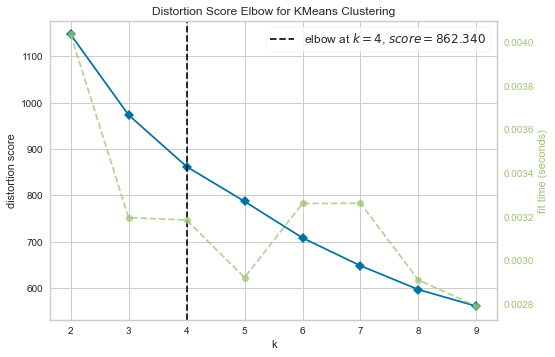

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Nombre de groupes
n = 3

km = KMeans(
    n_clusters= n, init='random',
    n_init=10, max_iter=300, 
    tol=1e-05, random_state=0
)

y_km = km.fit_predict(df_prm_scaled)

states_A, states_B, states_C, states_D = [], [], [], []
states_A_names, states_B_names, states_C_names, states_D_names = [], [], [], []
for i in range(len(states)):
    if y_km[i] == 0:
        states_A_names.append(states_names[states[i]])
        states_A.append(states[i])
    elif y_km[i] == 1:
        states_B_names.append(states_names[states[i]])
        states_B.append(states[i])
    elif y_km[i] == 2 and n >= 3:
        states_C_names.append(states_names[states[i]])
        states_C.append(states[i])
    elif y_km[i] == 3 and n>= 4:
        states_D_names.append(states_names[states[i]])
        states_D.append(states[i])

group_states = {}

for X in states:
  if X in states_A:
    group_states[X] = 'A'
  if X in states_B:
    group_states[X] = 'B'
  if X in states_C:
    group_states[X] = 'C'
  if X in states_D:
    group_states[X] = 'D'

print(states_A_names, len(states_A_names))
print(states_B_names, len(states_B_names))
print(states_C_names, len(states_C_names))
print(states_D_names, len(states_D_names))

# Elbow method K-means
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(df_prm_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [47]:
target_states = {'A': [], 'B': [], 'C':[], 'D':[]}
control_states = {'A': [], 'B': [], 'C':[], 'D':[]}

for X in states:
    if X in states_A and X in target_states_all:
        target_states['A'].append(X)
    elif X in states_A and X not in target_states_all:
        control_states['A'].append(X)
    elif X in states_B and X in target_states_all:
        target_states['B'].append(X)
    elif X in states_B and X not in target_states_all:
        control_states['B'].append(X)
    elif X in states_C and X in target_states_all:
        target_states['C'].append(X)
    elif X in states_C and X not in target_states_all:
        control_states['C'].append(X)
    elif X in states_D and X in target_states_all:
        target_states['D'].append(X)
    elif X in states_D and X not in target_states_all:
        control_states['D'].append(X)



print("Number of potential target states in group A = " + str(len(target_states['A'])) + "/" + str(len(states)))
print("Number of control states in group A = " + str(len(control_states['A'])) + "/" + str(len(states)))
print("Number of potential target states in group B = " + str(len(target_states['B'])) + "/" + str(len(states)))
print("Number of control states in group B = " + str(len(control_states['B'])) + "/" + str(len(states)))
print("Number of potential target states in group C = " + str(len(target_states['C'])) + "/" + str(len(states)))
print("Number of control states in group C = " + str(len(control_states['C'])) + "/" + str(len(states)))
print("Number of potential target states in group D = " + str(len(target_states['D'])) + "/" + str(len(states)))
print("Number of control states in group D = " + str(len(control_states['D'])) + "/" + str(len(states)))

Number of potential target states in group A = 9/49
Number of control states in group A = 12/49
Number of potential target states in group B = 6/49
Number of control states in group B = 13/49
Number of potential target states in group C = 2/49
Number of control states in group C = 7/49
Number of potential target states in group D = 0/49
Number of control states in group D = 0/49


Pourcentage des états ayant voté Trump en 2016 dans le groupe A: 19.047619047619047%
Pourcentage des états ayant voté Trump en 2016 dans le groupe B: 63.16%
Pourcentage des états ayant voté Trump en 2016 dans le groupe C: 77.78%
Pourcentage des états ayant voté Trump en 2016 dans le groupe D: nan%


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/2343322642.py:39: RuntimeWarning: invalid value encountered in double_scalars
  pct_D = 100*np.sum(vote_D)/len(vote_D)


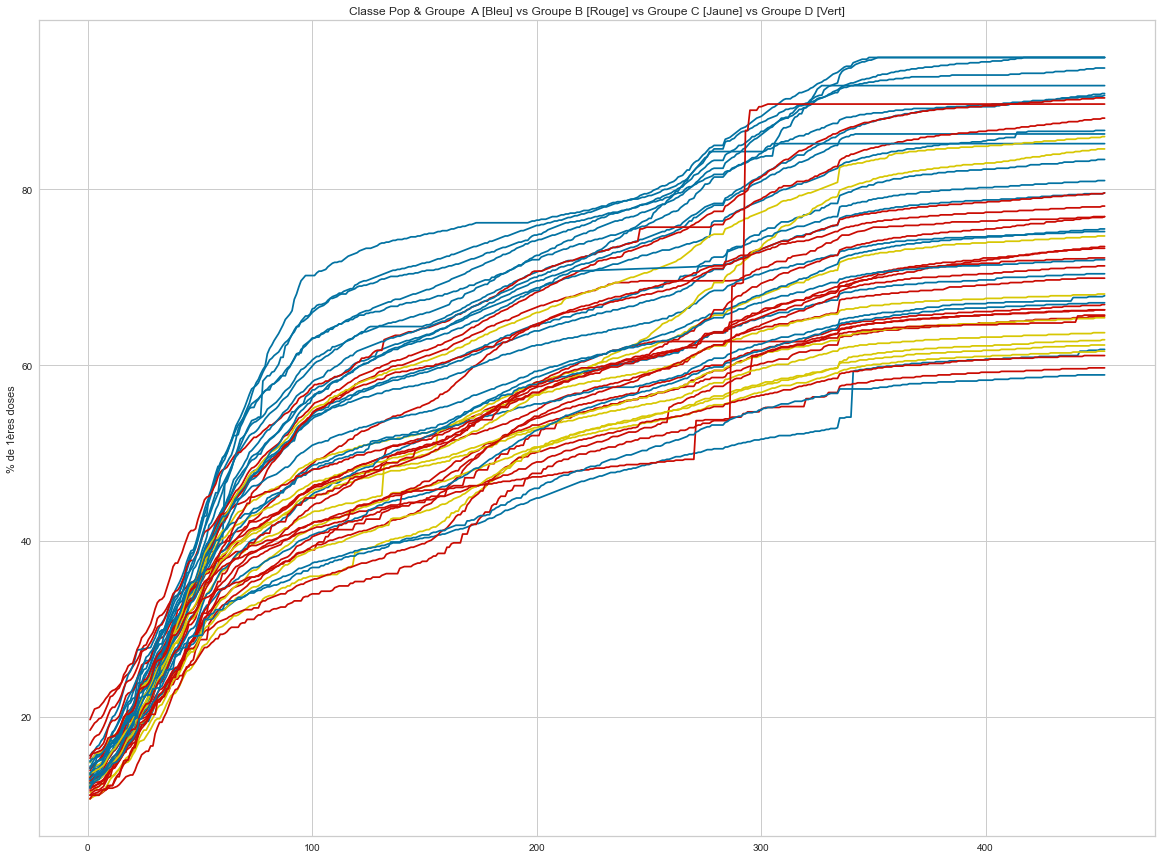

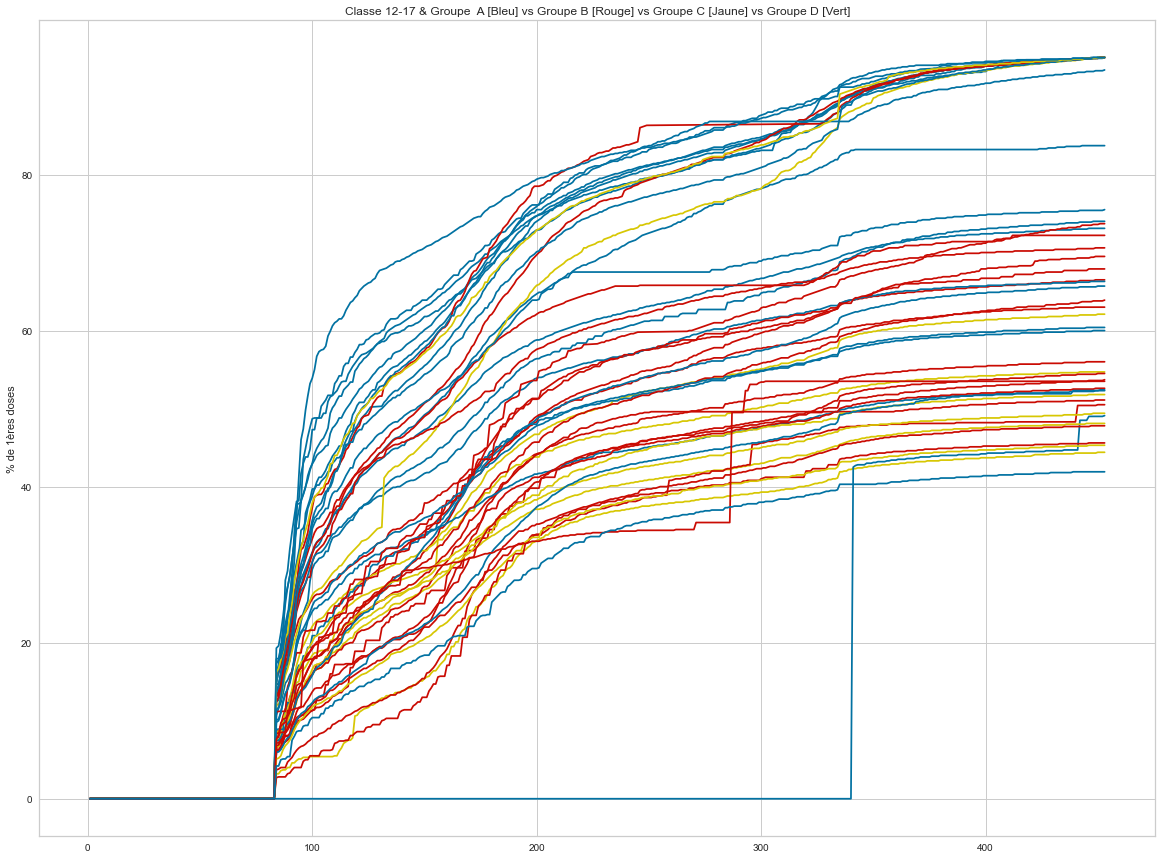

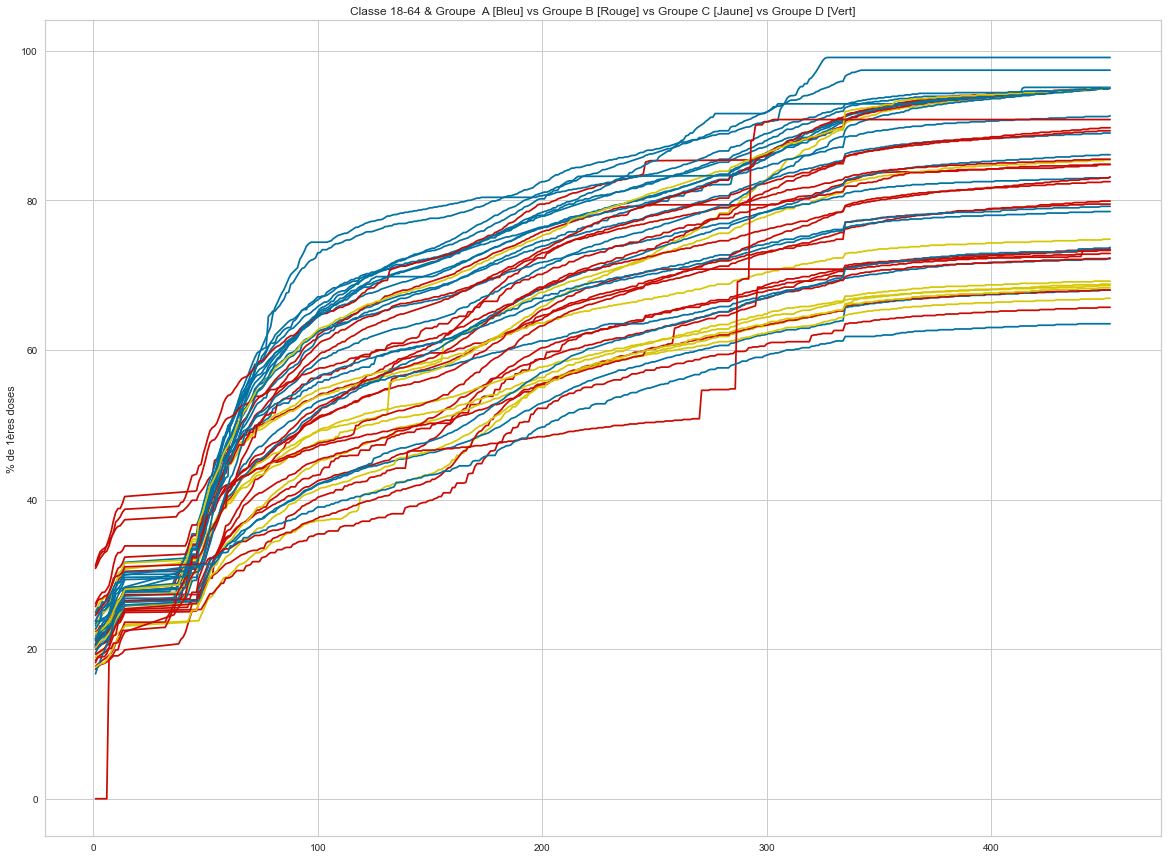

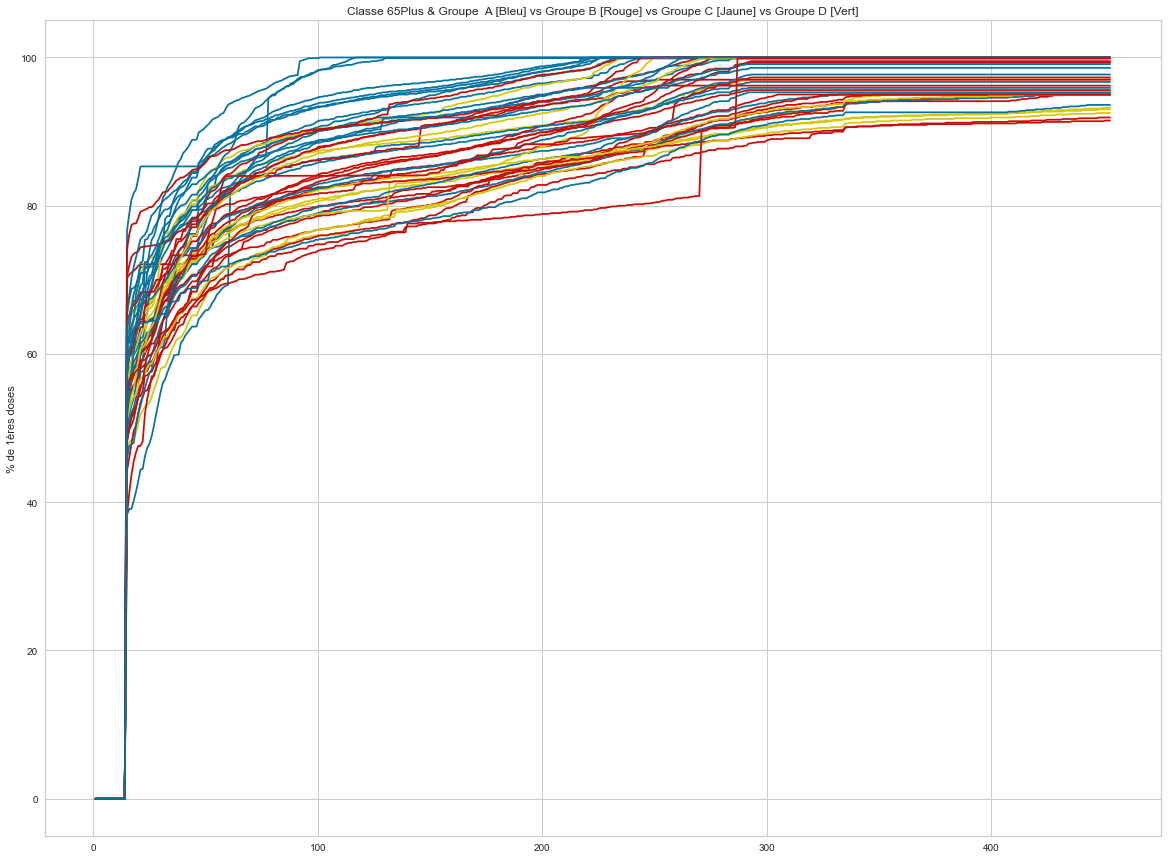

In [48]:
# Interprétation des groupes
# Remarque: même en supprimant les paramètres "politiques" (vote Trump 2020, 2016, ...)
#           le clustering génère les mêmes groupes. 

import matplotlib.pyplot as plt

vote_A, vote_B, vote_C, vote_D = [], [], [], []
states_A = np.concatenate((target_states['A'], control_states['A']))
states_B = np.concatenate((target_states['B'], control_states['B']))
states_C = np.concatenate((target_states['C'], control_states['C']))
states_D = np.concatenate((target_states['D'], control_states['D']))

for X in states_A:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_A.append(1)
    else:
        vote_A.append(0)       
pct_A = 100*np.sum(vote_A)/len(vote_A)

for X in states_B:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_B.append(1)
    else:
        vote_B.append(0)
pct_B = 100*np.sum(vote_B)/len(vote_B)

for X in states_C:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_C.append(1)
    else:
        vote_C.append(0)
pct_C = 100*np.sum(vote_C)/len(vote_C)

for X in states_D:
    if df_prm.loc[X, "2016 Trump vote share"] >= 0.5:
        vote_D.append(1)
    else:
        vote_D.append(0)
pct_D = 100*np.sum(vote_D)/len(vote_D)
        
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe A: "+str(pct_A)+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe B: "+str(np.round(pct_B,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe C: "+str(np.round(pct_C,2))+"%")
print("Pourcentage des états ayant voté Trump en 2016 dans le groupe D: "+str(np.round(pct_D,2))+"%")

for k in ["Pop","12-17","18-64","65Plus"]:
    plt.figure(figsize=(20,15))
    for X in states:
        c = 0
        if X in states_A:
            c = 'b'
        elif X in states_B:
            c = 'r'
        elif X in states_C:
            c = 'y'
        elif X in states_D:
            c = 'g'

        t = np.linspace(1,len(ls_dose1[k][X]), len(ls_dose1[k][X]))
        plt.plot(t, ls_dose1[k][X], color=c)
        
    plt.ylabel('% de 1ères doses')
    plt.title('Classe '+k+' & Groupe  A [Bleu] vs Groupe B [Rouge] vs Groupe C [Jaune] vs Groupe D [Vert]')
plt.show()


# Carte 
import plotly.express as px

c_list = []
for X in states:
    if X in states_A:
        c_list.append(1)
    elif X in states_B:
        c_list.append(2)
    elif X in states_C:
        c_list.append(3)
    elif X in states_D:
        c_list.append(4)    
    
fig = px.choropleth(locations=states, locationmode="USA-states", color=c_list, scope="usa")
fig.show()

### Logistic regression

Alabama


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



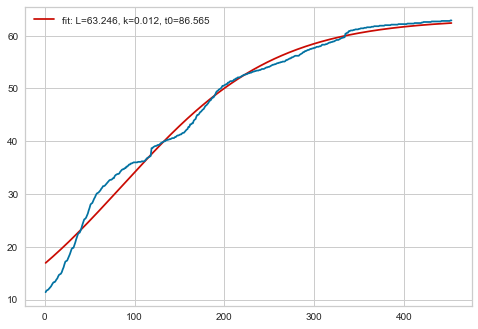

Arkansas


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



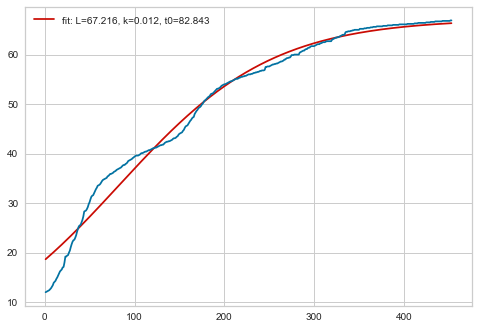

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



California


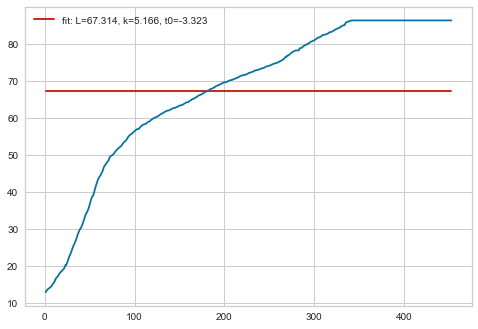

Colorado


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



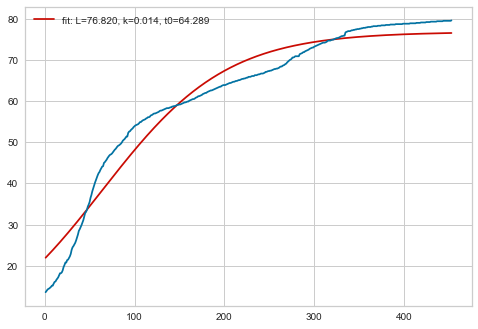

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Connecticut


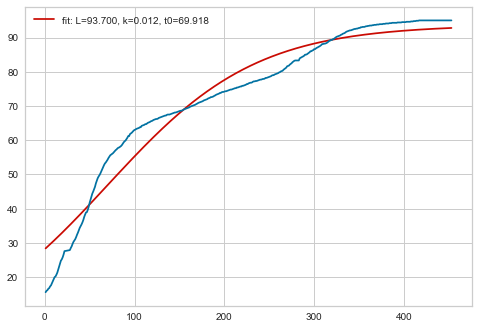

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Delaware


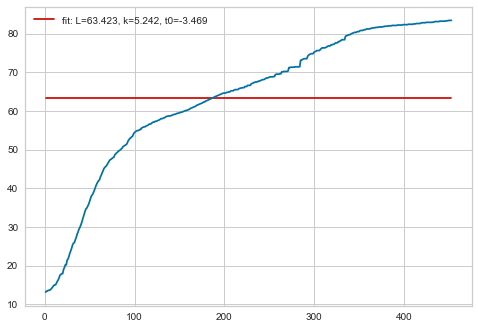

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Illinois


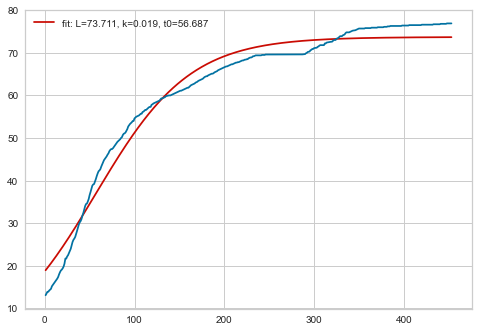

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Kentucky


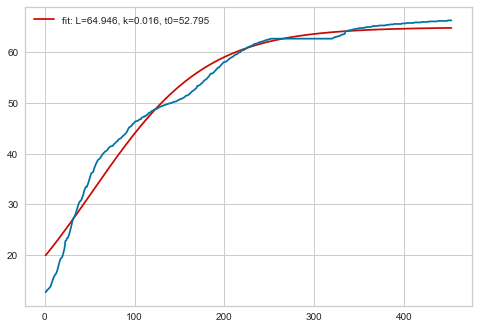

Maine


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



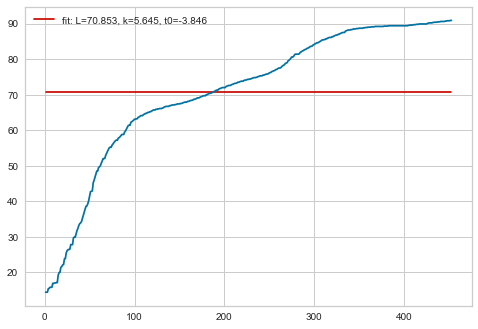

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



Maryland


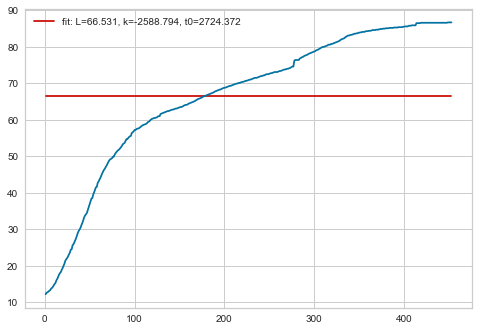

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Michigan


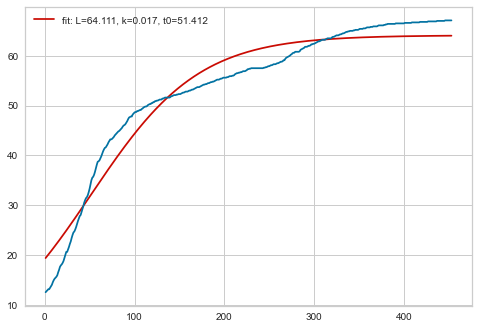

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Minnesota


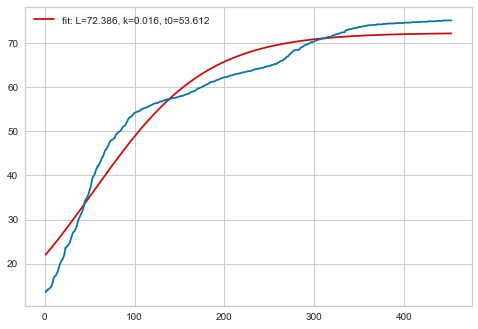

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



New Jersey


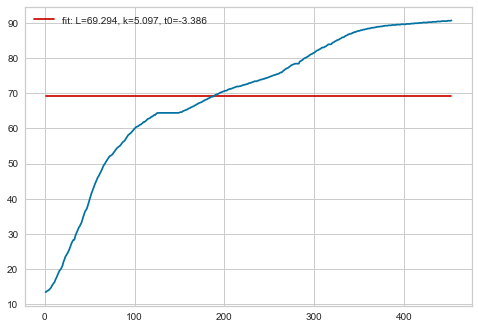

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



New York


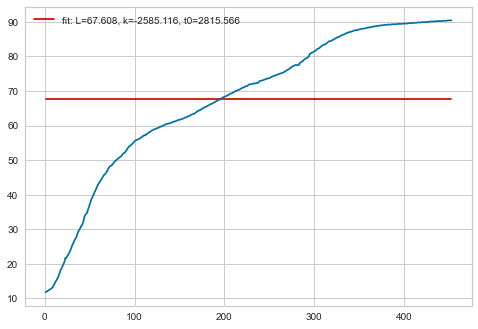

Ohio


/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



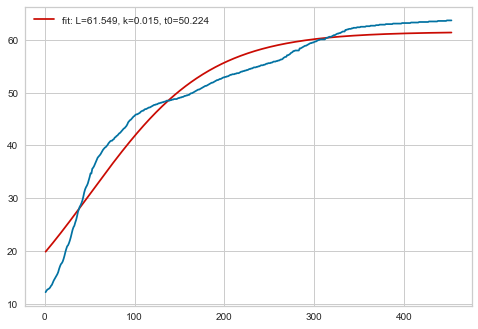

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp



Oregon


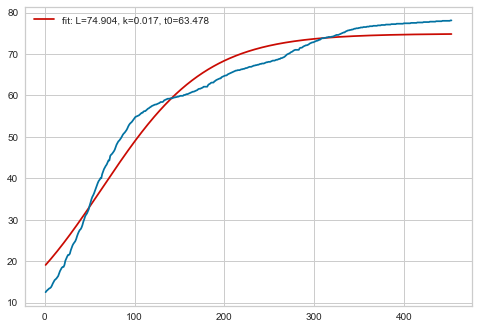

/var/folders/wt/2bjkn_kn4x51hmpsmpk3g35m0000gn/T/ipykernel_66594/1660531051.py:6: RuntimeWarning:

overflow encountered in exp

/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



West Virginia


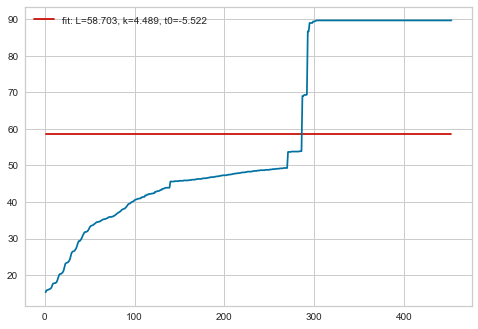

In [49]:
from scipy.optimize import curve_fit

for X in target_states_all:
  tspan = np.linspace(1,len(ls_dose1["Pop"][X]), len(ls_dose1["Pop"][X]))
  def func(t, L, k, tc):
    return L/(1+np.exp(-k*(t-tc)))

  popt, pcov = curve_fit(func, tspan, ls_dose1["Pop"][X])
  print(states_names[X])
  plt.plot(tspan, func(tspan, *popt), 'r-', label='fit: L=%5.3f, k=%5.3f, t0=%5.3f' % tuple(popt))
  plt.plot(tspan, ls_dose1["Pop"][X], 'b-')
  plt.legend()
  plt.show()

# 


## 2. Analyse en composantes principales
### Indépendant du synthetic control

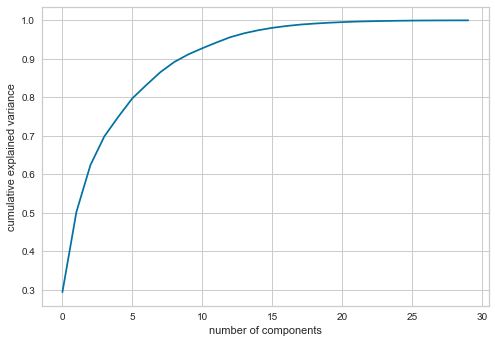

In [50]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(df_prm_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Text(0, 0.5, 'Percent Variance Explained')

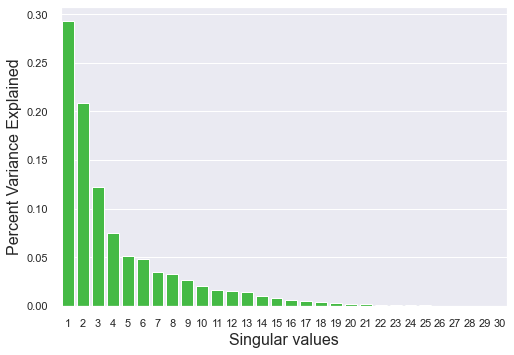

In [51]:
u, s, v = np.linalg.svd(df_prm_scaled, full_matrices=True)

v10 = v[:5,:]

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
var_explained

import seaborn as sns; sns.set()
sns.barplot(x=list(range(1,len(var_explained)+1)),
            y=var_explained, color="limegreen")
plt.xlabel('Singular values', fontsize=16)
plt.ylabel('Percent Variance Explained', fontsize=16)

In [52]:
prm_scaled_t = np.transpose(prm_scaled)
prm_pca = np.transpose(np.dot(v10, prm_scaled_t))

state_vector_pca = {}
for i in range(len(states)):
    state_vector_pca[states[i]] = prm_pca[i]

# 

## 3. Retour au synthetic control

In [53]:
def norm(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.dot(pred_diff, pred_diff_v)
    return np.sqrt(res)

L1 = 0.6
L2 = 0.1

def norm_reg(w, v, x, x1):
    pred = np.dot(np.transpose(x), w)
    pred_diff = x1 - pred
    pred_diff_v = np.multiply(pred_diff, v)
    res = np.sqrt(np.dot(pred_diff, pred_diff_v))
    res += L1*np.linalg.norm(w)
    res += L2*sum(np.abs(w))
    return res

def mspe(y1, y, w):
    interv = np.dot(np.transpose(y), w)
    interv_diff = y1 - interv
    res = np.dot(interv_diff, interv_diff)
    return res

In [54]:
# Définition des fonctions d'optimisation pour le contrôle synthétique

from scipy.optimize import minimize, fmin_slsqp

def constraint(w, v, x, x1):
    return np.sum(w) - 1

def con(v):
    return np.sum(v) - 1
cons = {'type':'eq', 'fun': con}

def mspe_opt_w(v_guess, w_guess, x, x1, y, y1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v_guess, x, x1), disp=False)
    return mspe(y1, y, w_opt)

def opt_v(v_guess, w_guess, x, x1, y, y1):
    v_opt = minimize(mspe_opt_w, v_guess, constraints = cons, bounds=[(0.0, 1.0)]*len(v_guess), 
             args=(w_guess, x, x1, y, y1), method='SLSQP')
    return v_opt.x

def opt_w(w_guess, v, x, x1):
    w_opt = fmin_slsqp(norm_reg, w_guess, f_eqcons=constraint, bounds=[(0.0, 1.0)]*len(w_guess),
             args=(v, x, x1), disp=False)
    return w_opt

In [75]:
# Définition des dates de début des incentives par état

import datetime
inc_t0 = {}
inc_t0["Pop"] = {}
inc_t0["18-64"] = {}
inc_t0["65Plus"] = {}

for X in target_states_all:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[:4]), int(t0_date_str[5:7]), int(t0_date_str[8:]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["Pop"][X] = t0
  inc_t0["18-64"][X] = t0
  inc_t0["65Plus"][X] = t0

inc_t0["12-17"] = {}

for X in target_states_all_1217:
  # 19/02/2021 approx première date à laquelle les % de vax sont non nuls
  start = datetime.date(2021,2,19)
  t0_date_str = dates[X]
  t0_date = datetime.date(int(t0_date_str[:4]), int(t0_date_str[5:7]), int(t0_date_str[8:]))
  t0 = t0_date - start
  t0 = t0.days
  inc_t0["12-17"][X] = t0

In [74]:
# Contrôle synthétique

import random

y1_prediction = {}

dfs={}
dfs['A'] = pd.DataFrame(columns=control_states['A'])
dfs['B'] = pd.DataFrame(columns=control_states['B'])
dfs['C'] = pd.DataFrame(columns=control_states['C'])
dfs['D'] = pd.DataFrame(columns=control_states['D'])

w_dic = {}

def synthetic(ls_dose1, state_vector_scaled, t_fit, t_test=10, states_choice=target_states_all, classe="Pop", plot=True):

  if classe == "12-17":
    states_choice = target_states_all_1217
    w_dic = {k:0 for k in target_states_all_1217}
  else:
    w_dic = {k:0 for k in target_states_all}
    
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")
  
  ress = 0

  for Y in states_choice:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target],group_states[X_target], 'is simulated with:')
      
      t0 = inc_t0[classe][X_target]
      
      L = "N/A"
      if classe != "12-17":
        if X_target in states_A:
            L = 'A'
        elif X_target in states_B:
            L = 'B'
        elif X_target in states_C:
            L = 'C'
        elif X_target in states_D:
            L = 'D'
      
      y1 = ls_dose1[classe][X_target][t0-t_fit:t0-t_test]
      y = []
      for X in control_states_all:    
          y.append(ls_dose1[classe][X][t0-t_fit:t0-t_test])

      y_post = []
      for X in control_states_all:    
          y_post.append(ls_dose1[classe][X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_states_all :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      # w_guess = np.array([1/k]*k)
      # v_guess = np.array([1/j]*j)

      w_guess = random.sample(range(0, 50), k)
      w_guess = np.array(w_guess)/sum(w_guess)
      v_guess = random.sample(range(0, 50), j)
      v_guess = np.array(v_guess)/sum(v_guess)
      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      w_dic[Y] = w_star
      V.append(np.concatenate(([L], np.round(v_star, 3))))
      
      

      y1_prediction[X_target] = np.dot(np.transpose(y_post), w_star)
      
      df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_states_all)

      # dfs[L]= pd.concat([dfs[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_states_all[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)
      

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],group_states[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[classe][X_target]), len(ls_dose1[classe][X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+ ' (Groupe '+L+' | Category '+str(category[X_target])+')')


        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[classe][X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(max(t0-t_fit,t0-40), t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom] (Groupe '+L+' | Category '+str(category[X_target])+')')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all:
            if X != X_target:
                plt.plot(t, ls_dose1[classe][X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all)):
            X = control_states_all[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[classe][X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[classe][X], 'r', linewidth=th)
        plt.plot(t, ls_dose1[classe][X_target], label='real')
        plt.plot(t, y1_prediction[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.axvspan(t0-t_fit, t0-t_test,color='blue',alpha=0.05, label= "fit timespan")
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')

      if not plot:
        ress +=1
        print(str(np.round(100*ress/len(target_states_all),2))+'% complete',end="\r")
  return V

In [58]:
import time


first_date = str(df_states['AK'].loc[0,["Date"]].values[0])
last_date = str(df_states['AK'].loc[len(df_states['AK'].loc[:,['Date']])-1,["Date"]].values[0])
print(first_date,last_date)

date_span = pd.date_range(start=first_date, end=last_date)

02/19/2021 05/17/2022


In [59]:
for classe in ["Pop", "12-17", "18-64", "65Plus"]:
    df1 = pd.DataFrame(ls_dose1[classe], index=date_span)
    df1.to_csv('CSV_results/doses_'+classe+'.csv')

### Fonctions d'analyse des résultats

In [81]:
# Delta entre pourcentage vacciné synthetic/réel intégré jusqu'à t0 Aire courbe pourcentage vacciné réel
# Proximité à 0 indique qualité du fit jusqu'à t0

from sklearn.metrics import mean_squared_error

def fit_q(ls_dose1, y1_prediction, after_t0=False, states_choose=target_states_all, classe="Pop"):
    fit_quality = []

    if after_t0 == False:
        for X in states_choose:
            t0 = inc_t0[classe][X]
            err = mean_squared_error(ls_dose1[X][:t0],y1_prediction[X][:t0])
            fit_quality.append(np.round(np.sqrt(err),2))
    else:
        for X in states_choose:
            t0 = inc_t0[classe][X]
            err = mean_squared_error(ls_dose1[X][t0+1:],y1_prediction[X][t0+1:])
            fit_quality.append(np.round(np.sqrt(err),2))

    df_fit = pd.DataFrame(fit_quality, index = states_choose, columns=['%'])

    return df_fit

In [61]:
#CALCUL DE P-VALUE APRES JANVIER

def p_value(ls_dose, y1_prediction):
  p_vls = {X:0 for X in target_states_all}

  for X in target_states_all:
    p_res = 0

    t0 = inc_t0[X]
    Ra = float(fit_q(ls_dose, y1_prediction).loc[[X],:].values[0][0])
    Rb = float(fit_q(ls_dose, y1_prediction, after_t0=True).loc[[X],:].values[0][0])
    r1 = Rb/Ra

    for Y in target_states_all:
      t0 = inc_t0[X]
      Ra = float(fit_q(ls_dose, y1_prediction).loc[[Y],:].values[0][0])
      Rb = float(fit_q(ls_dose, y1_prediction, after_t0=True).loc[[Y],:].values[0][0])
      r = Rb/Ra
      if r - r1 >= 0:
        p_res += 1
  
  p_vls[X] = np.round(p_res/len(states),2)

In [79]:
# Delta entre pourcentage de vaccination synthétique et réel n jours après t0

time_delta = [0, 30, 60, 90]
def delta_y(ls_dose1, y1_prediction, target_states=target_states_all, classe="Pop"):
  delta = []

  for X in target_states:
    t0 = inc_t0[classe][X]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = target_states, columns = time_delta)


  return df_delta

In [63]:
# Analyse de l'importance respective des coefficients des paramètres V*

def important_v(V):
  poids_v = pd.DataFrame(V, index=target_states_all, columns=np.concatenate((["Groupe"], df_prm.columns)))
  poids_v1 = poids_v.drop(columns=['Groupe'])
  poids_v1 = poids_v1.astype('float64')

  
  fig, axes = plt.subplots(11, 3, figsize=(18, 50))
  j = 0
  for c in poids_v1.columns:
    var = poids_v1.loc[:,c]
    ax = sns.barplot(ax=axes[int(np.trunc(j/3)),j%3], x=target_states_all,
            y=var, color="limegreen")
    # ax.set(yscale="log")
    ax.set(ylim=(0, 1))
    j+=1
    
  v_sum = poids_v1.sum()

  print("Most important parameters \n", v_sum.sort_values(ascending=False).head(), '\n')
  print("Least important parameters \n",v_sum.sort_values(ascending=False).tail())

### Comparaison des contrôles synthétiques pour un fit sur 20, 30, 40 ou 50 jours.

In [82]:
for classe in ["Pop","12-17", "18-64", "65Plus"]: 
    print(classe,'in progress')
    for t_fit in range(10,50,10):
        print("\rFit period",t_fit, "   ")
        V = synthetic(ls_dose1, state_vector_scaled, t_fit=t_fit, t_test=0, classe=classe, plot=False)
        df_delta = delta_y(ls_dose1[classe], y1_prediction, classe=classe)
        df_fit = fit_q(ls_dose1[classe], y1_prediction, classe=classe)

        df = pd.DataFrame(y1_prediction, index=date_span)
        df.to_csv('CSV_results/synthetics_fit'+str(t_fit)+'_'+classe+'.csv')

        w_DF = pd.DataFrame(w_dic, index=control_states_names)
        w_DF.to_csv('CSV_results/weights_fit'+str(t_fit)+'_'+classe+'.csv')


12-17 in progress
Fit period 10    
Fit period 20    
Fit period 30    
Fit period 40    


In [ ]:
# Dataframe de l'écart entre réel et synthétique à n jours
 
df_delta_f = pd.concat([df_delta30, df_delta40,df_delta50,df_delta60], axis=1)
df_fit_f = pd.concat([df_fit30, df_fit40,df_fit50,df_fit60], axis=1)

header = pd.MultiIndex.from_product([['------------- 30 ------------','------------ 40 ------------','------------- 50 ------------','------------- 60 ------------'],['+0','+30','+40','+90']], names=['t_fit','t0'])
df_delta_f.columns = header
df_delta_f.to_csv('Résultats/df_delta_f.csv', ',')
df_delta_f

In [ ]:
# Dataframe de MSPE de l'écart

df_fit_f

ls_fit = df_fit_f.to_numpy()

t = ['t_fit=30',40,50,60]
df_fit = pd.DataFrame(ls_fit, columns=t, index=target_states_all)
ax = sns.boxplot(data=df_fit)
df_fit.to_csv('Résultats/df_fit.csv', ',')
print("RMSPE on interval [0;t0]")
df_fit

###Analyse du choix de L1 et L2 dans Elastic Net

In [ ]:
elastic_analysis = []
ll = [0, 0.05, 0.1, 0.5, 1, 5]
for i in ll:
  L1 = i
  j_line = []
  print(i)
  for j in ll:
    L2 = j
    V = synthetic(ls_dose1, state_vector_scaled, t_fit=21,t_test=7, states_choice=['AR'], plot=False,)
    print('***')
    x = fit_q(ls_dose1, y1_prediction, states_choose=['AR']).iloc[0,0]
    j_line.append(x)
  elastic_analysis.append(j_line)


0.05
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
0.1
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
0.5
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
1
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
5
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***
 5.56% complete
***


In [ ]:
elastic_df = pd.DataFrame(elastic_analysis, index=ll, columns=['AL','AR','CA','CO']) #['L2='+str(10**i) for i in range(-5,1)])  
elastic_df

ValueError: ignored

##Placebo Tests

In [ ]:
import matplotlib.gridspec as gd


In [ ]:
# placebo state : synthetic control for control states 
# ici pour l'oregon 

y1_prediction_1 = {}
# dfs_placebo = {}

# dfs_placebo['A'] = pd.DataFrame(columns=control_states['A'])
# dfs_placebo['B'] = pd.DataFrame(columns=control_states['B'])
# dfs_placebo['C'] = pd.DataFrame(columns=control_states['C'])
# dfs_placebo['D'] = pd.DataFrame(columns=control_states['D'])

def synthetic_placebo(ls_dose, state_vector, t_fit, state, plot=True):
  V = []
  if plot==True:
    print("Les poids des différents états de contrôle dans le synthetic control: ")
    print("")

  for Y in control_states_all:
      
      X_target = Y
      if plot == True:
        print('The state of', states_names[X_target],group_states[X_target], 'is simulated with:')
      
      t0 = inc_t0[state]
      
      if X_target in states_A:
          L = 'A'
      elif X_target in states_B:
          L = 'B'
      elif X_target in states_C:
          L = 'C'
      elif X_target in states_D:
          L = 'D'
      
      control_states_all_modified = control_states_all.copy()
      control_states_all_modified.remove(X_target)

      y1 = ls_dose1[X_target][t0-t_fit:t0]
      y = []
      for X in control_states_all_modified:    
          y.append(ls_dose1[X][t0-t_fit:t0])

      y_post = []
      for X in control_states_all_modified:    
          y_post.append(ls_dose1[X])

  #   Choisir ici state_vector_scaled (35 paramètres normalisés) 
  #   ou state_vector_pca (5 principaux paramètres du PCA).
  #       Il semble que les 35 paramètres normalisés génèrent un synthetic 
  #       plus proche du réel sur la période avant l'intervention.
      x1 = state_vector_scaled[X_target]

      x = []
      for X in control_states_all_modified :    
              x.append(state_vector_scaled[X])
      
      k = len(x)
      j = len(x1)

      w_guess = np.array([1/k]*k)
      v_guess = np.array([1/j]*j)


      
      v_star = opt_v(v_guess, w_guess, x, x1, y, y1)
      w_star = opt_w(w_guess, v_star, x, x1)
      V.append(np.concatenate(([L], np.round(v_star, 3))))
      
      

      y1_prediction_1[X_target] = np.dot(np.transpose(y_post), w_star)
      
      #df_new_row = pd.DataFrame(data=np.array([w_star]), columns=control_states_all_modified)

      # dfs_placebo[L]= pd.concat([dfs_placebo[L],df_new_row], ignore_index=True)
      
      inf = 0.01
      states_star = {}
      
      for k in range(len(w_star)):
          if w_star[k]>inf:
              states_star[control_states_all_modified[k]] = w_star[k]
      
      sortedDict = sorted(states_star.items(), key=lambda x: x[1], reverse=True)

      if plot == True:
        for k in range(len(sortedDict)):
          print('   ', states_names[sortedDict[k][0]],group_states[sortedDict[k][0]],np.round(sortedDict[k][1],3)*100,'%' )

        t = np.linspace(1,len(ls_dose1[X_target]), len(ls_dose1[X_target]))
        t_zoom = np.linspace(t0-40,t0+70, 110)
        
        plt.figure(figsize=(20, 16))
        plt.subplot(2, 2, 1) # row 1, col 2 index 1
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+ ' (Groupe '+L+')')

        plt.subplot(2, 2, 2) # row 1, col 2 index 1
        plt.plot(t_zoom, ls_dose1[X_target][t0-40:t0+70], label='real')
        plt.plot(t_zoom, y1_prediction_1[X_target][t0-40:t0+70], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target] + ' [zoom] (Groupe '+L+')')
        

        plt.subplot(2, 2, 3) # row 1, col 2 index 1
        for X in control_states_all_modified:
            if X != X_target:
                plt.plot(t, ls_dose1[X], 'b--', linewidth=0.5)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs autres états')

        plt.subplot(2, 2, 4) # row 1, col 2 index 1
        for i in range(len(control_states_all_modified)):
            X = control_states_all_modified[i]
            if X != X_target:
              if X in control_states[L]:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'g', linewidth=th)
              else:
                th = 2*w_star[i]
                plt.plot(t, ls_dose1[X], 'r', linewidth=th)
        plt.plot(t, ls_dose1[X_target], label='real')
        plt.plot(t, y1_prediction_1[X_target], label='synthetic')
        lbl = "t0=" + t0_date_str
        plt.axvline(x=t0, ls='--', label= lbl)
        plt.legend()
        plt.title(states_names[X_target]+' vs états contrôles finaux')

        plt.show()
        print('')
  return V

In [ ]:
# Delta placebo between synthetic and real vaccination rates x days after t0
time_delta = [0, 30, 60, 90]
def delta_y_placebo(ls_dose, y1_prediction,state):
  delta = []

  for X in control_states_all:
    t0 = inc_t0[state]
    delta += [[np.round(y1_prediction[X][t0+d] -ls_dose1[X][t0+d],2) for d in time_delta]]

  df_delta = pd.DataFrame(delta, index = control_states_all, columns = time_delta)


  return df_delta

In [ ]:
# Placebo Test - Illinois : 

state = 'IL'

dic_placebo30 = {}
dic_delta_placebo30 = {}

dic_placebo40 = {}
dic_delta_placebo40 = {}

dic_placebo50 = {}
dic_delta_placebo50 = {}

dic_placebo60 = {}
dic_delta_placebo60 = {}

V = synthetic_placebo(ls_dose1, state_vector_scaled, 30, state, plot=False)
y1_prediction30 = y1_prediction_1.copy()
dic_placebo30[state] = y1_prediction30
dic_delta_placebo30[state] = delta_y_placebo(ls_dose1, y1_prediction30, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 40, state, plot=True)
y1_prediction40 = y1_prediction_1.copy()
dic_placebo40[state] = y1_prediction40
dic_delta_placebo40[state] = delta_y_placebo(ls_dose1, y1_prediction40, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 50, state, plot=False)
y1_prediction50 = y1_prediction_1.copy()
dic_placebo50[state] = y1_prediction50
dic_delta_placebo50[state] = delta_y_placebo(ls_dose1, y1_prediction50, state)

V = synthetic_placebo(ls_dose1, state_vector_scaled, 60, state, plot=False)
y1_prediction60 = y1_prediction_1.copy()
dic_placebo60[state] = y1_prediction60
dic_delta_placebo60[state] = delta_y_placebo(ls_dose1, y1_prediction60, state)

dics_delta = [df_delta30, df_delta40, df_delta50, df_delta60]
dics_placebo = [dic_placebo30, dic_placebo40, dic_placebo50, dic_placebo60]
dics_delta_placebo = [dic_delta_placebo30, dic_delta_placebo40, dic_delta_placebo50, dic_delta_placebo60]



In [ ]:
dic_placebo30[state]

In [ ]:
df_placebo30 = pd.DataFrame.from_dict(dic_placebo30[state])
df_delta_placebo30 =  pd.DataFrame.from_dict(dic_delta_placebo30[state])

df_placebo40 = pd.DataFrame.from_dict(dic_placebo40[state])
df_delta_placebo40 =  pd.DataFrame.from_dict(dic_delta_placebo40[state])

df_placebo50 = pd.DataFrame.from_dict(dic_placebo50[state])
df_delta_placebo50 =  pd.DataFrame.from_dict(dic_delta_placebo50[state])

df_placebo60 = pd.DataFrame.from_dict(dic_placebo60[state])
df_delta_placebo60 =  pd.DataFrame.from_dict(dic_delta_placebo60[state])
 
df_placebo30.to_csv('Résultats/df_placebo30.csv', ',', header=True, index=True)
df_delta_placebo30.to_csv('Résultats/df_delta_placebo30.csv', ',', header=True, index=True)

df_placebo40.to_csv('Résultats/df_placebo40.csv', ',', header=True, index=True)
df_delta_placebo40.to_csv('Résultats/df_delta_placebo40.csv', ',', header=True, index=True)

df_placebo50.to_csv('Résultats/df_placebo50.csv', ',', header=True, index=True)
df_delta_placebo50.to_csv('Résultats/df_delta_placebo50.csv', ',', header=True, index=True)

df_placebo60.to_csv('Résultats/df_placebo60.csv', ',', header=True, index=True)
df_delta_placebo60.to_csv('Résultats/df_delta_placebo60.csv', ',', header=True, index=True)

In [ ]:
fig = plt.figure(figsize=(20, 16))
outer = gd.GridSpec(2, 2, wspace=0.32, hspace=0.32)

for i in range(4):
        inner = gd.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[i], wspace=0.3, hspace=0.3, )

        for j in range(4):
            days = [0, 30, 60, 90]
            fitting = [30, 40 , 50 , 60]
            ax = plt.Subplot(fig, inner[j])
            X = list(dics_delta_placebo[i][state][days[j]])
            Z = X + [dics_delta[j].loc[state][days[j]]]
            t = ax.hist(Z, bins = 40)
            p = np.percentile(Z, 95)
            ax.axvline(x = p, color = "red", label = "95th percentile")
            ax.axvline(x = dics_delta[j].loc[state][days[j]], color = "green", label = str(state))
            ax.set_title("Delta at " + str(days[j]) + " day(s) (" + str(fitting[i]) + " fitting days)")
            fig.add_subplot(ax)

fig.suptitle("Placebo Tests for " + str(states_names[state]), y = 0.93, fontsize = 20)
fig.show()


In [ ]:

dic_placebo30 = {}
dic_delta_placebo30 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 30, state, plot=False)
    y1_prediction30 = y1_prediction_1.copy()
    dic_placebo30[state] = y1_prediction30
    dic_delta_placebo30[state] = delta_y_placebo(ls_dose1, y1_prediction30, state)


In [ ]:

dic_placebo40 = {}
dic_delta_placebo40 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 40, state, plot=False)
    y1_prediction40 = y1_prediction_1.copy()
    dic_placebo40[state] = y1_prediction40
    dic_delta_placebo40[state] = delta_y_placebo(ls_dose1, y1_prediction40)


In [ ]:

dic_placebo50 = {}
dic_delta_placebo50 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 50, state, plot=False)
    y1_prediction50 = y1_prediction_1.copy()
    dic_placebo50[state] = y1_prediction50
    dic_delta_placebo50[state] = delta_y_placebo(ls_dose1, y1_prediction50)


In [ ]:

dic_placebo60 = {}
dic_delta_placebo60 = {}
for state in target_states_all : 
    V = synthetic_placebo(ls_dose1, state_vector_scaled, 60, state, plot=False)
    y1_prediction60 = y1_prediction_1.copy()
    dic_placebo60[state] = y1_prediction60
    dic_delta_placebo60[state] = delta_y_placebo(ls_dose1, y1_prediction60)


In [ ]:
# Visualisation histogramme placebo 

dics_delta = [df_delta30, df_delta40, df_delta50, df_delta60]
dics_placebo = [dic_placebo30, dic_placebo40, dic_placebo50, dic_placebo60]
dics_delta_placebo = [dic_delta_placebo30, dic_delta_placebo40, dic_delta_placebo50, dic_delta_placebo60]


for state in target_states_all :
    fig = plt.figure(figsize=(20, 16))
    outer = gd.GridSpec(2, 2, wspace=0.32, hspace=0.32)

    for i in range(4):
            inner = gd.GridSpecFromSubplotSpec(2, 2,
                            subplot_spec=outer[i], wspace=0.3, hspace=0.3, )

            for j in range(4):
                days = [0, 30, 60, 90]
                fitting = [30, 40 , 50 , 60]
                ax = plt.Subplot(fig, inner[j])
                X = list(dics_delta_placebo[i][days[j]])
                Z = X + [dics_delta[j].loc[state][days[j]]]
                t = ax.hist(Z, bins = 30)
                p = np.percentile(Z, 95)
                ax.axvline(x = p, color = "red", label = "95th percentile")
                ax.axvline(x = dics_delta[j].loc[state][days[j]], color = "blue", label = str(state))
                ax.set_title("Delta at " + str(days[j]) + " day(s) (" + str(fitting[j]) + " fitting days)")
                fig.add_subplot(ax)

    fig.suptitle("Placebo Tests for " + str(state), y = 0.93, fontsize = 20)
    fig.show()